In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary

import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from adabelief_pytorch import AdaBelief

# for using sampling with gradient-tracking when selecting an action
from torch.distributions import Categorical

In [2]:
class Policy(nn.Module):

    def __init__(self, input_dim, action_dim, hidden):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden)
        self.fc2 = nn.Linear(hidden, action_dim)
        
    def forward(self, state):
        out = F.relu(self.fc1(state))
        out = F.softmax(self.fc2(out), dim=1)
        return out 

In [3]:
class Agent():
    def __init__(self, env, n_epi, max_steps, gamma, plot_freq, input_dim, action_dim, hidden, learning_rate, device):
        # environment parameter
        self.gamma = gamma
        self.env = env

        # trainig parameter
        self.device = device
        self.n_epi = n_epi
        self.max_steps = max_steps
        self.plot_freq = plot_freq
        self.frame_cnt = 0

        # network paramter
        self.lr = learning_rate
        self.policy = Policy(input_dim, action_dim, hidden).to(self.device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=self.lr)
        
    def select_action(self, state):
        prob = self.policy(torch.FloatTensor(state).view(1, -1).to(self.device)) 
        cate_dist = Categorical(prob) 
        action = cate_dist.sample() 
        return action.item(), cate_dist.log_prob(action), prob.detach().cpu().numpy() 
    
    def update_policy(self, epi_history):
        accum_R = 0
        losses = torch.zeros(len(epi_history)).to(self.device)
        
        for idx, [log_p, r] in enumerate(epi_history[::-1]):
            accum_R += r * (self.gamma**idx)
            one_step_loss = -log_p * accum_R
            losses[idx] = one_step_loss
        loss = losses.sum()
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss
    
    def train(self):
        score_hist = []
        loss_hist = []
        
        for i_episode in range(1, self.n_epi+1):
            epi_history = []
            rewards = [] 
            score = 0

            state = self.env.reset() 
            for step in range(self.max_steps):
                action, log_prob, prob = self.select_action(state)
                next_state, reward, done, _ = env.step(action)
                
                epi_history.append([log_prob, reward])
                state = next_state
                score += reward
                self.frame_cnt += 1
                if done: break
            score_hist.append(score)
            loss = self.update_policy(epi_history)
            loss_hist.append(loss)
            if i_episode%self.plot_freq == 0:
                self._plot_status(i_episode, loss_hist, score_hist)
    
    def _plot_status(self, i_episode, loss_hist, score_hist):
        subplot_params = [
            (121, f"Scores in episode_{i_episode}", score_hist),
            (122, f"Policy loss in episode:{i_episode}", loss_hist),
        ]

        clear_output(True)
        plt.figure(figsize=(10, 5), facecolor='w')
        for loc, title, values in subplot_params:
            plt.subplot(loc)
            plt.title(f'Frame:{self.frame_cnt} '+title)
            plt.plot(values)
        plt.show()

In [4]:
device = torch.device(
            "cuda:1" if torch.cuda.is_available() else "cpu"
        )
env_name_list = ["CartPole-v0", "MountainCar-v0", "LunarLander-v2"]
env_name = env_name_list[2]
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

print("Environment: ", env_name)
print("State Dimension:", state_dim, " Action Dimension:", action_dim)

n_epi = 100000 
max_steps = 1000
gamma = 0.99
plot_freq = 10

hidden = 128
learning_rate = 0.001

Environment:  LunarLander-v2
State Dimension: 8  Action Dimension: 4


In [8]:
0.99**80

0.4475232137638106

In [5]:
agent = Agent(
            env,
            n_epi,
            max_steps,
            gamma,
            plot_freq,
            state_dim,
            action_dim,
            hidden,
            learning_rate,
            device)

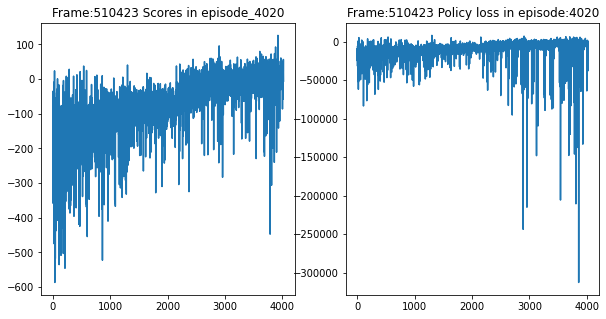

In [ ]:
agent.train() 